In [1]:
import json
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tqdm import tqdm
import random
import numpy as np

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
merchant_id = '11167ECFF94860EA'

In [4]:
file = '/data/predict/'+merchant_id+'/'+merchant_id+'_logs.json'

In [5]:
users = {}
with open(file, encoding='utf8') as f:
    for line in tqdm(f):
        data = json.loads(line)
        if data['visitor_id'] not in users:
            users[data['visitor_id']] = []
        for prod_idx in data['viewed_products']:
            try:
                users[data['visitor_id']].append(prod_idx)
            except ValueError: 
                print('Sktrain_labelsiped ' + prod_idx)

59810it [00:00, 121184.19it/s]


In [6]:
users_lens = list(map(lambda x: len(x), users.values()))

In [7]:
print(len(users.keys()))

15710


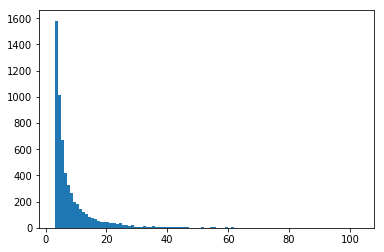

In [8]:
d = plt.hist(users_lens, bins=100, range=(3, 103))

In [9]:
products = {}
for u in users.values():
    for pid in u:
        products[pid] = 1
product_idxs = products.keys()
product_ids = {v: k for k, v in enumerate(product_idxs)}
number_of_classes = len(product_idxs)

In [10]:
print(number_of_classes)

2043


In [32]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [12]:
def dedup(seq):
    seen = set()
    seen_add = seen.add

    return [x for x in seq if not (x in seen or seen_add(x))]

In [42]:

def generate_from_array(arr):
    while True:
        random.shuffle(arr)
        for i in arr: 
            yield i
    

In [180]:
import math

max_batch_size = 128

class Grouping:
    def __init__(self):
        self.dict = {}
    
    def add(self,key,value):
        if key not in self.dict:
            self.dict[key] = []
            
        self.dict[key].append(value)
        
    def __iter__(self):
        return iter(self.dict.values())
            
        

class DataCollector:
    def __init__(self, get_random):
        self.data = Grouping()
        self.get_random = get_random
    
    def add(self,seq):
        missing_idx = random.randint(0, len(seq)-1)
        
        self.add_real_example(seq, missing_idx)
        self.add_fake_example(seq, missing_idx)
    
    def add_real_example(self, seq, missing_idx):
        l = self.__list_without(seq, missing_idx)
        self.data.add(len(l), (l, seq[missing_idx], 1))
        
    def add_fake_example(self, seq, missing_idx):
        l = self.__list_without(seq, missing_idx)
        r = seq[missing_idx]
        while r == seq[missing_idx]:
            r = self.get_random()
            
        self.data.add(len(l), (l, r, 0))
    
    def get_batches(self, max_batch_size):
        batches = []
        for batch in self.__yield_raw_batches(max_batch_size):
            seq_batch = []
            miss_batch = []
            label_batch = []
            
            for item in batch:
                seq_batch.append(item[0])
                miss_batch.append([item[1]])
                label_batch.append([item[2]])
            
            batches.append((
                [np.array(seq_batch),np.array(miss_batch)],
                np.array(label_batch)
            ))
        
        return batches
    
    def get_generator(self, max_batch_size):
        batches = self.get_batches(max_batch_size)
        return generate_from_array(batches), len(batches)
    
    def __yield_raw_batches(self, max_batch_size):
        for group in self.data:
            random.shuffle(group)
            for batch in chunks(group, max_batch_size):
                yield batch
    
    def __list_without(self, l, missing_idx):
        return l[:missing_idx] + l[missing_idx+1:]
        

frequencies = [0]*number_of_classes

for uid,products in tqdm(users.items()):
    for idx in dedup(list(map(lambda x: product_ids[x], products))):
        frequencies[idx] += 1

def get_random():
    r = random.randint(0,sum(frequencies))
    c = 0
    for i in range(number_of_classes):
        if frequencies[i] + c > r:
            return i
        c += frequencies[i]

        
train_data_collector = DataCollector(get_random)
valid_data_collector = DataCollector(get_random)


valid_seqs = []
for uid,products in tqdm(users.items()):
    ids = dedup(list(map(lambda x: product_ids[x], products)))
    #ids = list(map(lambda x: product_ids[x], products))
    
    if len(ids) > 1:
        is_validation = random.random() < 0.1
        
        collector = valid_data_collector if is_validation else train_data_collector
        if is_validation:
            valid_seqs.append(ids)
        
        for i in range(len(ids)):
            collector.add(ids)
            
train_generator, train_batches = train_data_collector.get_generator(max_batch_size)
valid_generator, valid_batches = valid_data_collector.get_generator(max_batch_size)

100%|██████████| 15710/15710 [00:06<00:00, 2614.58it/s]


In [67]:
#train_batches = []
#for i in range(len(product_pair_labels)):
#    train_batches.append(
#        (
#            [np.array([product_pair_data[0][i]]), np.array([product_pair_data[1][i]])],
#            np.array([product_pair_labels[i]])
#        )
#    )
#    
#valid_batches = []
#for i in range(len(val_product_pair_labels)):
#    valid_batches.append(
#        (
#            [np.array([val_product_pair_data[0][i]]), np.array([val_product_pair_data[1][i]])],
#            np.array([val_product_pair_labels[i]])
#        )
#    )
#
#train_generator = generate_from_array(train_batches)
#valid_generator = generate_from_array(valid_batches)

## Training

In [54]:
import bcolz
emb_weights = bcolz.open('/data/predict/'+merchant_id+'/'+merchant_id+'_embedding')[:]

In [181]:
from keras.models import Model
from keras.layers import Input, Flatten, Embedding, GRU, Dense, Dropout, concatenate
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

factors = 100
n_hidden = 50

seq_input = Input(shape=(None,))
x = Embedding(number_of_classes, factors, weights=emb_weights, trainable=False)(seq_input)
x = GRU(n_hidden, input_shape=(None,n_hidden))(x)

miss_input = Input(shape=(1,))
y = Embedding(number_of_classes, factors, weights=emb_weights, trainable=False)(miss_input)
y = Flatten()(y)

x = concatenate([x, y])

x = Dense(n_hidden, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model([seq_input, miss_input], output)


In [182]:
model.compile(
    loss='binary_crossentropy', 
    metrics=['binary_accuracy'], 
    optimizer=Nadam()
)

In [183]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, None, 100)    204300      input_17[0][0]                   
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 100)       204300      input_18[0][0]                   
__________________________________________________________________________________________________
gru_9 (GRU

In [184]:
model.fit_generator(
    train_generator, 
    validation_data=valid_generator, 
    steps_per_epoch=train_batches,
    validation_steps=valid_batches,
    epochs=1
)

Epoch 1/1
509/509 [==============================] - 8s 16ms/step - loss: 0.6818 - binary_accuracy: 0.5461 - val_loss: 0.6699 - val_binary_accuracy: 0.5752


In [165]:
def predict_missing(seq):
    preds = []
    for i in range(len(seq)):
         preds.append(
             list(model.predict([np.array([seq[:i+1]]*number_of_classes),np.array(range(number_of_classes))])[:,0])
         )
    return np.array(preds)

In [166]:
import csv
with open('/data/predict/'+merchant_id+'/'+merchant_id+'_missing_variable_length_model_id_map.csv', 'w',encoding='utf8') as csvfile:
    spamwriter = csv.writer(csvfile)
    for line in product_idxs:
        spamwriter.writerow([line])

## Eye ball validation

In [167]:
import csv

In [168]:
product_map = {}
with open('/data/predict/'+merchant_id+'/'+merchant_id+'_catalog.csv', 'r', encoding='utf8') as csvfile:
    spamreader = csv.reader(csvfile)
    header = next(spamreader)
    item_id = header.index('item')
    image_url = header.index('image')
    title = header.index('title')
    link = header.index('link')
    
    for row in spamreader:
        product_map[row[item_id]] = [row[image_url], row[title], row[link]]

In [169]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [190]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def product_to_url(product):
    try:
        
        return [product] + product_map[list(product_idxs)[product]] + [list(product_idxs)[product]]
    except KeyError:
        return [product,'http://www.lackuna.com/wp-content/themes/fearless/images/missing-image-640x360.png','UNKNOWN','', '']

def display_session(session):
    products = list(map(product_to_url, session))
    predictions = predict_missing(session)
    html = '<table>'
    seen = set()
    for i,product in enumerate(products):
        html += '<tr>'
        html += '<th style="text-align:center;width:120px">'
        html += '<img src="' + product[1] + '" width="130"><br/>' 
        html += '<a href="'+str(product[3])+'">' + str(product[4]) + '</a></br>' + str(product[2])
        html += '</th><td style="background-color:black;"></td>'
        top_idx = list(np.argsort(predictions[i])[::-1])
        seen.add(product[0])
        
        j = 0
        for pred in top_idx:
            #if pred in seen:
            #    continue
                                
            if i < len(products) - 1 and pred == products[i+1][0]:
                style = 'style="border:3px dashed red;"'
            else:
                style = ''
                
            pred_data = product_to_url(pred)
            html += '<td style="width:130px"><img src="' + pred_data[1] + '" '+style+' width="130"><br/>' 
            html += '<a href="'+str(pred_data[3]) + '">' +str(pred_data[4]) + '</a></br>' + str(pred_data[2]) + '</td>'
            j+=1
            if j > 5:
                break
                
        html += '</tr>'
    html += '</table>'

    core_display(HTML(html))

display_session(random.choice(valid_seqs))

2041757Damen-Fleeceshirt in dezenter Farbe,,2042325Polycotton-Bettwäsche mit modernem Muster,UNKNOWN,2039693Damen-Steppjacke mit 2 Reißverschluss-Taschen,UNKNOWN,UNKNOWN,UNKNOWN
2040197Damen-Anorak mit Druckknöpfen,,2042325Polycotton-Bettwäsche mit modernem Muster,UNKNOWN,UNKNOWN,1674986Damen-Top,2043176Damen-Bluse mit Rüschen,2041003Herren-Unterhose mit modernen Bündchen
2041756Damen-Fleeceshirt mit Reißverschluss,,UNKNOWN,2039632Baby-Mädchen-Body mit Reh-Frontaufdruck,"1680856Jumbo-Teelichthalter, Ø ca. 8-9cm",2040184Herren-Retroshorts in toller Farbverlaufs-Optik,"1687003Damen-Komfort-Socken, 3er Pack",2040976Herren-Thermo-Unterhose mit Ziernähten
2042874Damen-Shirt mit Jacquard-Streifen,,UNKNOWN,UNKNOWN,"2040726Damen-Schlafanzug mit Blümchen-Muster, 2-teilig","1693817Gesundheitssocken mit Baumwolle, 3er Pack","1687003Damen-Komfort-Socken, 3er Pack",2045500Fidget Cube - das Original


In [127]:
display_session(np.array([product_ids['2041197']]))

"2041197Damen-Strickjacke im offenen Cardigan-Stil, große Größen",,UNKNOWN


In [128]:
grouped_by_last_item = {}
for batch in user_valid_batches:
    for session in batch[0]:
        if session[-1] not in grouped_by_last_item:
            grouped_by_last_item[session[-1]] = []
        grouped_by_last_item[session[-1]].append(session)


NameError: name 'user_valid_batches' is not defined

In [ ]:
gr = random.choice(grouped_by_last_item)
s1 = random.choice(gr)
s2 = random.choice(gr)
display_session(s1)
display_session(s2)